In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import DateOffset
from pandas.plotting import lag_plot, autocorrelation_plot
import numpy as np
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt
from sklearn.metrics import mean_absolute_error

# Defaults for plotting
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()

# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))
sns.mpl.rc('xtick', labelsize=13)    # fontsize x tick labels
sns.mpl.rc('ytick', labelsize=13)    # fontsize y tick labels
sns.mpl.rc('legend', fontsize=14)    # fontsize legend

## Load data

In [16]:
# Define paths
snp_data_path = '../data/snp_prices_daily_Jan_2019_May_2020.csv'
btc_data_path = '../data/bitcoin_may_2016_april_2020.csv'
snp_trends_data_path = '../data/snp_trends.csv'
btc_trends_data_path = '../data/bitcoin_trends.csv'

# Keep only the 'Data' and 'Close' (closing pirce) columns for both dataset
snp = pd.read_csv(snp_data_path, usecols=['Date','Close']).set_index('Date')
snp.index = pd.to_datetime(snp.index)
snp.rename(columns={'Close': 'Price'}, inplace=True)
# snp = snp.asfreq(DateOffset(days=1))

btc = pd.read_csv(btc_data_path, usecols=['Date','Close']).set_index('Date')
btc.index = pd.to_datetime(btc.index)
btc.rename(columns={'Close': 'Price'}, inplace=True)
btc = btc.asfreq(DateOffset(days=1))

# S&P 500
<hr>

In [17]:
# Replace the NaN values in the weekends with the the values close values in friday
# for i in range(len(snp)):
#     if snp.iloc[i].isnull().any():
#         snp.iloc[i] = snp.iloc[i-1]

In [18]:
snp.head(10) # Weekends are missing

,Price
Date,
2019-01-02,2510.030029
2019-01-03,2447.889893
2019-01-04,2531.939941
2019-01-07,2549.689941
2019-01-08,2574.409912
2019-01-09,2584.959961
2019-01-10,2596.639893
2019-01-11,2596.260010
2019-01-14,2582.610107


### Plots

Text(0.5, 1.0, 'S&P 500 Closing price')

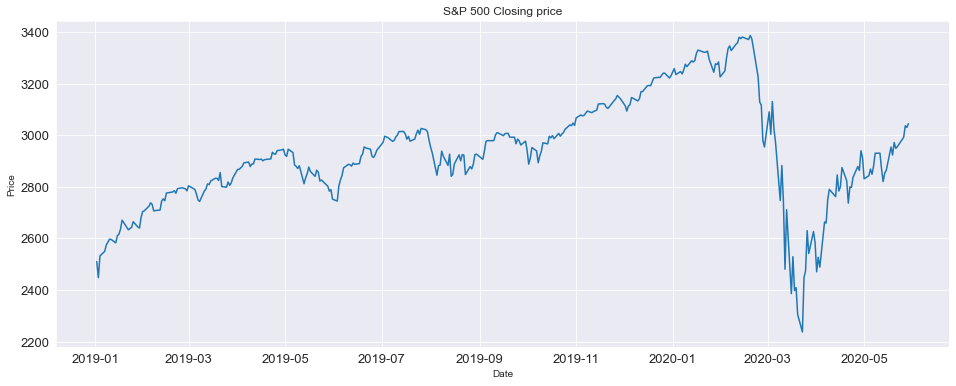

In [19]:
sns.lineplot(data=snp, x=snp.index, y=snp.Price).set_title('S&P 500 Closing price')

### Lag plot with lag(-1), lag(-2), lag(-5), lag(-12)

We can see that for some plots the data gather around a diagonal line.
We can say that there is some form of correlation between our series and the lagged ones.

This holds especially for `lag(-1)`, `lag(-2)`, `lag(-12)`. `Lag(-5)` seems to be the less correlated of them all.

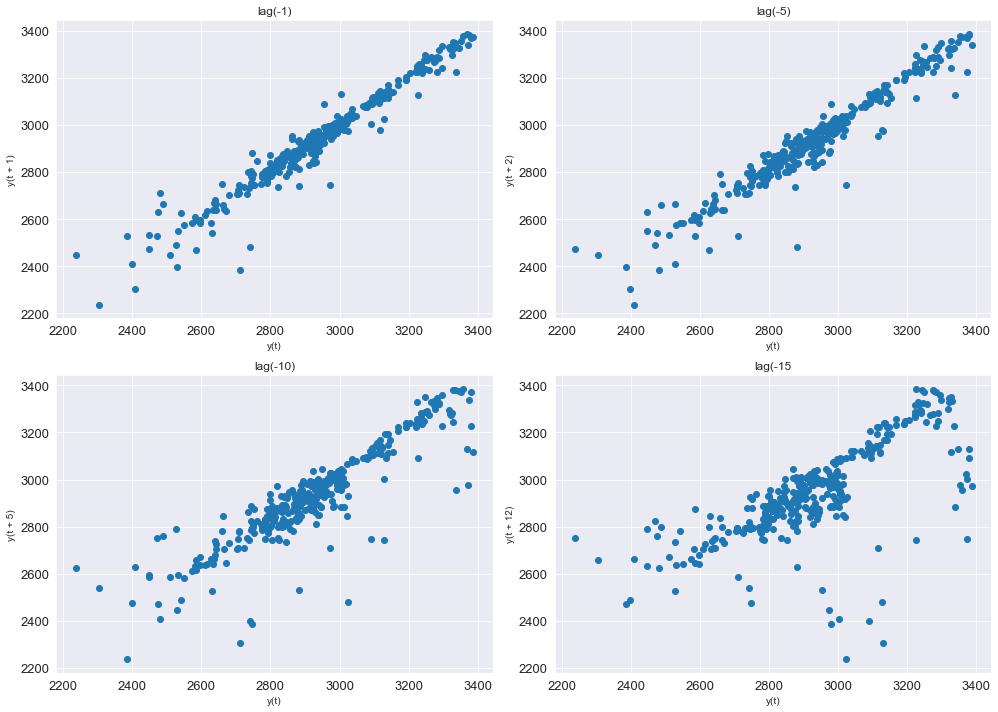

In [20]:
# Create the figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

# Create all the lag plots: -1. -2, -5 , -12
lag_plot(snp[['Price']], 1,  ax=ax[0][0])
ax[0][0].set_title('lag(-1)')

lag_plot(snp[['Price']], 2,  ax=ax[0][1])
ax[0][1].set_title('lag(-5)')

lag_plot(snp[['Price']], 5,  ax=ax[1][0])
ax[1][0].set_title('lag(-10)')

lag_plot(snp[['Price']], 12, ax=ax[1][1])
ax[1][1].set_title('lag(-15')

fig.tight_layout()
plt.show()

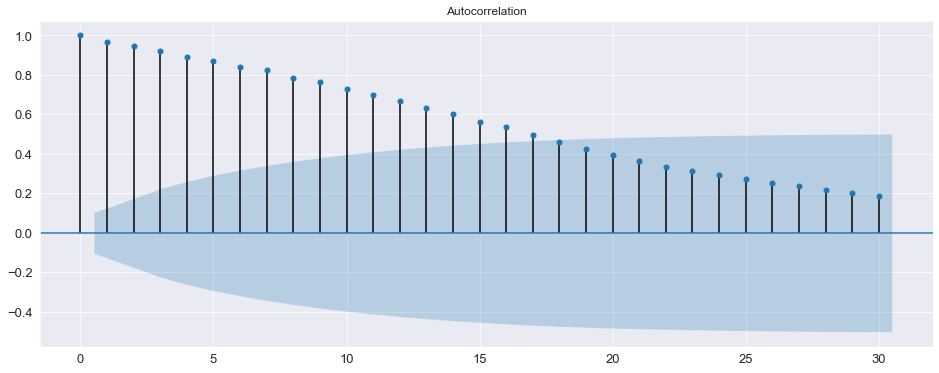

In [21]:
# plot the autocorrelation for 30 days
plot_acf(snp, lags=30)
plt.show()

## Build models

Use the `AutoReg` model from `statsmodels` to build and fit auto regression models to our data
<hr>

### In-sample models
Predict data that are already seen. Feed the whole data to the models and predict the whole time series

### Base in-sample model

In [22]:
base_snp = AutoReg(snp.Price.values, lags=[1, 2, 3, 4, 5]).fit()
print(base_snp.summary())


                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  355
Model:                     AutoReg(5)   Log Likelihood               -1821.965
Method:               Conditional MLE   S.D. of innovations             44.110
Date:                Fri, 18 Dec 2020   AIC                              7.613
Time:                        02:37:05   BIC                              7.691
Sample:                             5   HQIC                             7.644
                                  355                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     82.1307     34.531      2.378      0.017      14.452     149.809
y.L1           0.6986      0.053     13.128      0.000       0.594       0.803
y.L2           0.4950      0.064      7.754      0.0

Base in sample MAE: 11.985


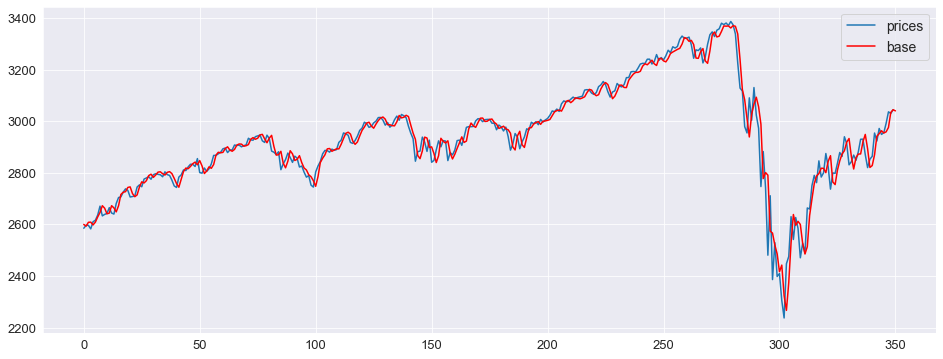

In [23]:
# In sample prediction for both models
pred_base = base_snp.predict(start=5, end=len(snp.Price.values))
# pred_trends = trends_model.predict(start=snp.index[0], end=snp.index[-1])

# Compute MAE
mae_base = mean_absolute_error(snp.iloc[4:,0], pred_base)
# mae_trends = mean_absolute_error(snp.iloc[5:,0], pred_trends[5:])
print('Base in sample MAE: %.3f' % mae_base)
# print('Trends in sample MAE: %.3f' % mae_trends)

# Plor in sample predictions (this is not the figure to reproduce!)
plt.plot(snp.iloc[5:, 0].values )
plt.plot(pred_base, 'red')
# plt.plot(pred_trends[12:], 'green')
plt.legend(['prices', 'base'])#, 'trends'])

# Bitcoin


In [24]:
btc.head() # Weekends are missing

,Price
Date,
2016-12-01,756.773987
2016-12-02,777.943970
2016-12-03,771.155029
2016-12-04,773.872009
2016-12-05,758.700012


Text(0.5, 1.0, 'Bitcoin Closing price')

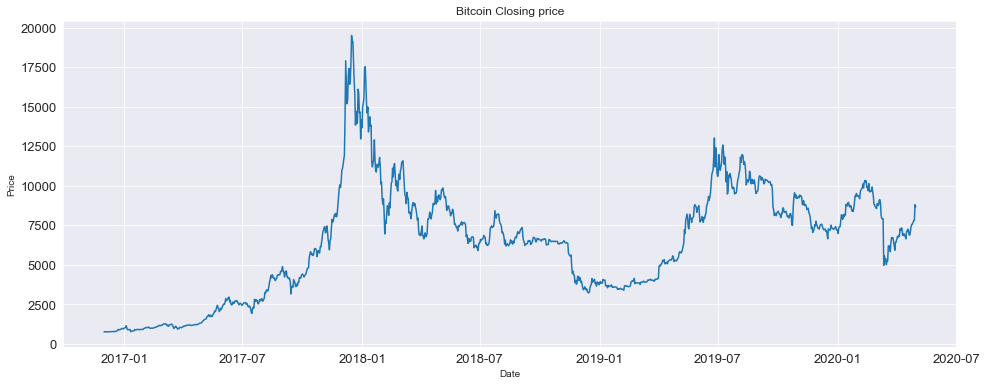

In [25]:
sns.lineplot(data=btc, x=btc.index, y=btc.Price).set_title('Bitcoin Closing price')

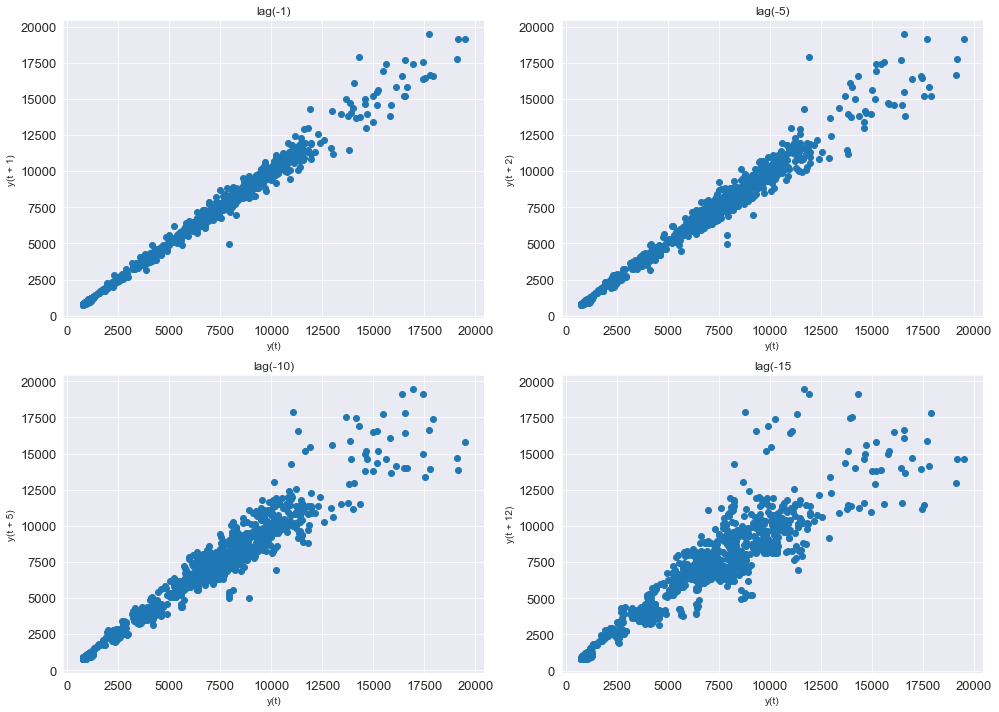

In [26]:
# Create the figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

# Create all the lag plots: -1. -2, -5 , -12
lag_plot(btc[['Price']], 1,  ax=ax[0][0])
ax[0][0].set_title('lag(-1)')

lag_plot(btc[['Price']], 2,  ax=ax[0][1])
ax[0][1].set_title('lag(-5)')

lag_plot(btc[['Price']], 5,  ax=ax[1][0])
ax[1][0].set_title('lag(-10)')

lag_plot(btc[['Price']], 12, ax=ax[1][1])
ax[1][1].set_title('lag(-15')

fig.tight_layout()
plt.show()

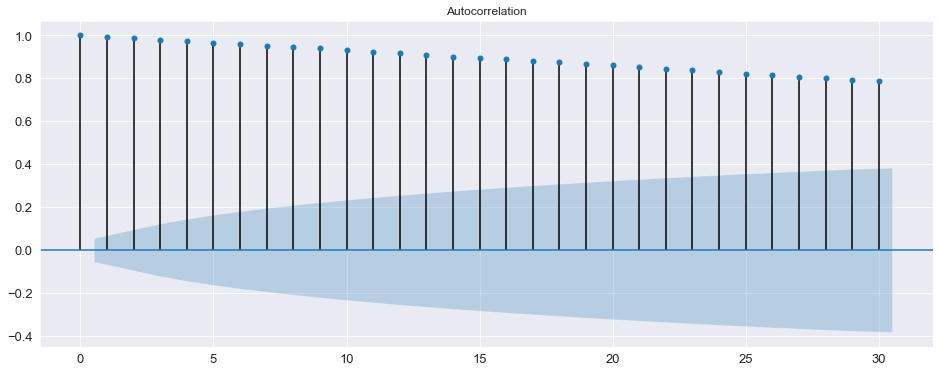

In [27]:
# plot the autocorrelation for 30 days
plot_acf(btc, lags=30)
plt.show()

In [39]:
from textblob import TextBlob

#sentiment = pd.read_csv('../data/fin_news.csv')


In [49]:
b = TextBlob((sentiment.iloc[256]['title']))
print(b)
print(b.sentiment)




Agilent Reports Purchase Of Cobalt Light Systems For £40M In Cash
Sentiment(polarity=0.4, subjectivity=0.7)


In [68]:
sent_small = sentiment.iloc[:50000]
sent_small['sent'] = sent_small['title'].apply(lambda x: TextBlob(x).sentiment[0])

In [70]:
print(sent_small[sent_small['sent'] != 0].count())

Unnamed: 0    16013
title         16013
date          16006
stock         16006
sent          16013
dtype: int64
